A notebook to create the submission(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    Stacked, SubstitutionOneHot, DNase, Classifier, Regression, RegressionClassifier
from utils import write_submission

## Load data

Read the training data with added conservation information.

In [2]:
training = pd.read_csv('data/cagi5_df.csv')
training.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Read the submission data

In [3]:
submission = pd.read_csv(
    'data/submission-with-cons.tsv',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments,phastCon,phyloP,GerpN,GerpRS
1897,1,155271429,T,G,PKLR,NaN,NaN,NaN,NaN,NaN,0.016,-0.555,3.97,-7.040
12318,22,19710894,A,C,GP1BB,NaN,NaN,NaN,NaN,NaN,0.246,0.455,3.95,2.790
11470,20,42984174,A,G,HNF4A,NaN,NaN,NaN,NaN,NaN,0.696,-0.295,4.96,2.650
3463,1,209989361,T,C,IRF6,NaN,NaN,NaN,NaN,NaN,0.797,-0.338,5.28,-0.236
10823,19,11199960,A,T,LDLR,NaN,NaN,NaN,NaN,NaN,0.002,-0.682,3.21,-5.780
4139,1,209989718,T,A,IRF6,NaN,NaN,NaN,NaN,NaN,0.004,0.455,2.19,-2.020


Identify all the submission regions to check they match those in the training data.

In [4]:
sub_regions = submission['Promoter_Enhancer'].unique()
sub_regions.sort()
print(sub_regions)
train_regions = training['regulatory_element'].str.slice(start=8).unique()
train_regions.sort()
print(train_regions)

['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB' 'MYC'
 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']
['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB'
 'MYCrs6983267' 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']


TODO: Make sure that MYC region names match between training and submission data frames.

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
    'colsample_bytree': 0.7524052235178577,
    'learning_rate': 0.39783003619093765,
    'max_depth': 7,
    'min_child_weight': 4.0467095559059505,
    'reg_alpha': 0.030682622499703896,
    'reg_lambda': 0.40505823486422077,
    'subsample': 1.0
}

### Choose features

In [7]:
def make_features(test):
    if test:
        stacked = Stacked('test-deep-dnase-cons')
        deepseadiffs = DeepSeaSNP(filename_fmt='deepsea-test_{}_preds.npy')
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11-test_{}_preds_v1.npy')
        crnn = DeepSeaSNP(filename_fmt='crnn_500_200-9-16-test_{}_preds_v1.npy')
    else:
        stacked = Stacked('deep-dnase-cons')
        deepseadiffs = DeepSeaSNP(filename_fmt='deepsea_{}_preds.npy')
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11_{}_preds_v1.npy')
        crnn = DeepSeaSNP(filename_fmt='crnn_500_200-9-16_{}_preds_v1.npy')
    dnase = DNase(test=test)
    conservation = Conservation()
    # subst = SubstitutionOneHot(test=test)
    # enhancer1hot = EnhancerOneHot(test=test)
    # snpcontext2 = SNPContext(context_size=2, test=test)
    # snpcontext4 = SNPContext(context_size=4, test=test)
    return MultiFeatures([deepseadiffs, crnn, dnase, conservation, stacked])
train_features = make_features(False)
test_features = make_features(True)

## Fit model

In [8]:
# import models, importlib
# importlib.reload(models)
# from models import Regression, Classifier, StackedRegressionClassifier
tuned_params['max_depth'] = 9
regression = Regression(features=train_features)
classifier = Classifier(features=train_features)
stacked = RegressionClassifier(regression, classifier)
X_train = stacked.get_features(training)
y_train = stacked.get_response(training)
stacked.fit(X_train, y_train)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Make predictions

In [9]:
X_test = test_features.get_features(submission)
predictions = stacked.predict(X_test, submission.index)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb
10900,0.437929,0.197789,-1,0.263744,-0.360640,0.364282
6009,0.399432,0.283884,-1,0.180684,-0.199150,0.316684
9541,0.238690,0.354959,0,0.094263,0.028070,0.406351
8942,0.251110,0.314391,0,0.036439,0.013443,0.434499
12175,0.313608,0.313444,0,0.030771,-0.055386,0.372948
11364,0.259093,0.296717,0,0.132093,-0.106779,0.444190


Call which variants are present from the regression predictions

In [10]:
# import models, importlib
# importlib.reload(models)
# from models import call_variants_from_regression
predictions = stacked.make_submission(predictions)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb,Direction,P_Direction,Confidence,SE
6018,0.579977,0.210374,-1,0.204248,-0.059470,0.209649,-1,0.579977,0.204248,0.1
8468,0.269515,0.315585,0,0.031086,-0.001643,0.414900,0,0.414900,0.031086,0.1
9138,0.286551,0.278483,0,0.055991,0.030197,0.434965,0,0.434965,0.055991,0.1
8079,0.298376,0.310780,0,0.034385,0.016901,0.390844,0,0.390844,0.034385,0.1
6625,0.264502,0.306338,0,0.079231,-0.006543,0.429160,0,0.429160,0.079231,0.1
1203,0.298286,0.289556,0,0.058793,-0.011528,0.412158,0,0.412158,0.058793,0.1


Plot the predicted values against the probability that they are correct coloured by called direction.

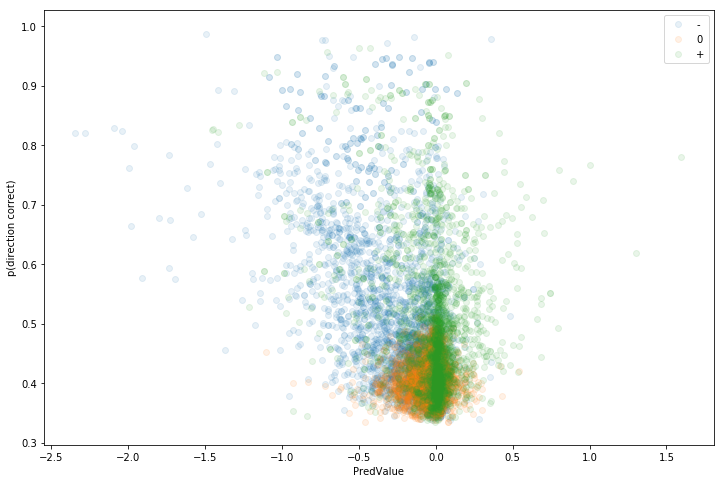

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
alpha = .1
neg = -1 == predictions['Direction']
zero = 0 == predictions['Direction']
pos =  1 == predictions['Direction']
ax.scatter(predictions.loc[neg, 'PredValue'], predictions.loc[neg, 'P_Direction'], label='-', alpha=alpha)
ax.scatter(predictions.loc[zero, 'PredValue'], predictions.loc[zero, 'P_Direction'], label='0', alpha=alpha)
ax.scatter(predictions.loc[pos, 'PredValue'], predictions.loc[pos, 'P_Direction'], label='+', alpha=alpha)
ax.legend()
ax.set_xlabel('PredValue')
ax.set_ylabel('p(direction correct)')
None

## Load confidence standard errors

In [12]:
conf_se = np.load('data/conf-se.npy')
predictions['SE'] = conf_se

### Save predictions

In [13]:
# import utils, importlib
# importlib.reload(utils)
for col in ['Direction', 'P_Direction', 'Confidence', 'SE']:
    submission[col] = predictions[col]
submission['Comments'] = '*'
write_submission(submission, 'data/submission-7.txt')

Writing submission to: data/submission-7.txt
